In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Awal Setup

In [ ]:
# Load dataset SMS Spam dari Hugging Face
# Dataset ini berisi pesan SMS dengan label spam/ham
from datasets import load_dataset

dataset = load_dataset("ucirvine/sms_spam")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [ ]:
# Hitung distribusi label untuk melihat balance dataset
# Label 0 = Ham (non-spam), Label 1 = Spam
from collections import Counter

raw_ds = dataset["train"]
label_counts = Counter(raw_ds["label"])
label_counts

Counter({0: 4827, 1: 747})

In [ ]:
raw_ds[:3]

{'sms': ['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n',
  'Ok lar... Joking wif u oni...\n',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"],
 'label': [0, 0, 1]}

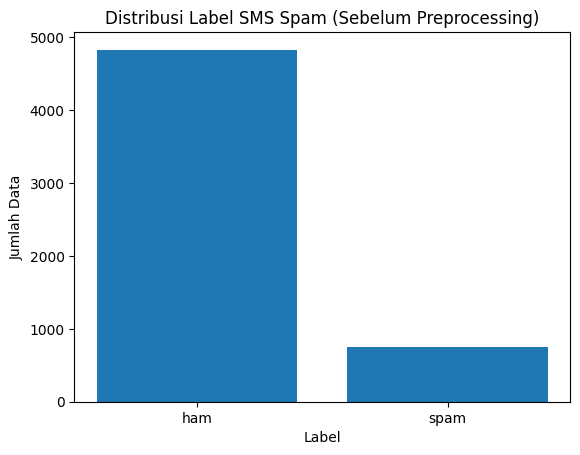

In [ ]:
# Visualisasi distribusi label menggunakan bar chart
# Membantu memahami apakah dataset imbalanced
import matplotlib.pyplot as plt

labels = ["ham", "spam"]
counts = [label_counts[0], label_counts[1]]

plt.bar(labels, counts)
plt.title("Distribusi Label SMS Spam (Sebelum Preprocessing)")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.show()

# Preprocessing

In [ ]:
# Fungsi preprocessing untuk membersihkan teks
# 1. Lowercase: konversi ke huruf kecil
# 2. Hapus URL: buang link http/www
# 3. Hapus karakter khusus: hanya simpan huruf, angka, spasi
# 4. Normalisasi spasi: ganti multiple spaces jadi satu
import re

def preprocess_text(text):
    text = text.lower()                          # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)   # hapus URL
    text = re.sub(r"[^a-z0-9\s]", " ", text)     # hapus simbol
    text = re.sub(r"\s+", " ", text)             # normalisasi spasi
    return text.strip()

In [ ]:
# Terapkan preprocessing ke seluruh dataset
# Menambahkan kolom `clean_text` agar dapat dibandingkan dengan raw text
processed_ds = raw_ds.map(
    lambda x: {
        "clean_text": preprocess_text(x["sms"])
    }
)

Map:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [7]:
for i in range(3):
    print("RAW  :", raw_ds[i]["sms"])
    print("CLEAN:", processed_ds[i]["clean_text"])
    print("-"*60)


RAW  : Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

CLEAN: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
------------------------------------------------------------
RAW  : Ok lar... Joking wif u oni...

CLEAN: ok lar joking wif u oni
------------------------------------------------------------
RAW  : Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

CLEAN: free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c s apply 08452810075over18 s
------------------------------------------------------------


In [ ]:
# Analisis panjang teks setelah preprocessing
# Penting untuk menentukan max_length saat padding
lengths = [len(text.split()) for text in processed_ds["clean_text"]]

print("Rata-rata panjang:", sum(lengths)/len(lengths))
print("Maksimum panjang :", max(lengths))

Rata-rata panjang: 16.108180839612487
Maksimum panjang : 190


In [ ]:
# Split dataset menjadi Train (70%), Validation (15%), Test (15%)
# Stratify memastikan proporsi spam/ham sama di semua split

# Step 1: Train vs Temp (30%)
split_1 = processed_ds.train_test_split(
    test_size=0.3,
    seed=42,
    stratify_by_column="label"
)

# Step 2: Temp → Validation + Test (masing-masing 15%)
split_2 = split_1["test"].train_test_split(
    test_size=0.5,
    seed=42,
    stratify_by_column="label"
)

train_ds = split_1["train"]
val_ds   = split_2["train"]
test_ds  = split_2["test"]

In [ ]:
# Ekstrak fitur (X) dan label (y) dari setiap split
# X = teks yang sudah dibersihkan
# y = label (0=ham, 1=spam)
X_train = train_ds["clean_text"]
y_train = train_ds["label"]

X_val = val_ds["clean_text"]
y_val = val_ds["label"]

X_test = test_ds["clean_text"]
y_test = test_ds["label"]

len(X_train), len(X_val), len(X_test)

(3901, 836, 837)

# Built Model

## Model 1 BiLSTM

### Tokenizer

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Hyperparameter untuk tokenizer BiLSTM
MAX_VOCAB = 10000     # jumlah kata unik maksimal (cukup untuk SMS)
MAX_LEN   = 100       # panjang sequence setelah padding (SMS pendek)

In [ ]:
# Buat tokenizer dan fit ke training data
# oov_token: token untuk kata yang tidak ada di vocabulary
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

### Tranform Teks -> Sequence

In [ ]:
# Konversi teks menjadi sequence of integers
# Setiap kata direpresentasikan oleh index-nya di vocabulary
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

### Padding Sequence

In [ ]:
# Padding sequences agar semua memiliki panjang yang sama (MAX_LEN)
# padding="post": tambahkan 0 di akhir sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

### Bangun Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


In [ ]:
# Bangun arsitektur BiLSTM
# 1. Embedding: konversi index ke vector dense
# 2. Bidirectional LSTM: membaca sequence dari 2 arah (forward & backward)
# 3. Dropout: regularisasi untuk mencegah overfitting
# 4. Dense: output layer dengan sigmoid untuk binary classification
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile Model

In [ ]:
# Compile model dengan:
# - Loss: binary_crossentropy (untuk binary classification)
# - Optimizer: adam (adaptive learning rate)
# - Metrics: accuracy untuk monitoring
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

### NUMPY + DTYPE

In [ ]:
# Konversi data ke numpy array dengan dtype yang sesuai
# int32 untuk input sequences, float32 untuk labels
import numpy as np

X_train_pad = np.asarray(X_train_pad, dtype="int32")
X_val_pad   = np.asarray(X_val_pad, dtype="int32")
X_test_pad  = np.asarray(X_test_pad, dtype="int32")

y_train = np.asarray(y_train, dtype="float32")
y_val   = np.asarray(y_val, dtype="float32")
y_test  = np.asarray(y_test, dtype="float32")

### Training Model

In [ ]:
# Training model BiLSTM
# - epochs=10: jumlah iterasi penuh melalui training data
# - batch_size=32: jumlah sample per gradient update
# - validation_data: untuk monitoring performa di data yang tidak dilihat saat training
history = model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8812 - loss: 0.3494 - val_accuracy: 0.9809 - val_loss: 0.0818
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9857 - loss: 0.0528 - val_accuracy: 0.9785 - val_loss: 0.0871
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9925 - loss: 0.0307 - val_accuracy: 0.9653 - val_loss: 0.1454
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9965 - loss: 0.0152 - val_accuracy: 0.9821 - val_loss: 0.0892
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9987 - loss: 0.0071 - val_accuracy: 0.9797 - val_loss: 0.1008
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9809 - val_loss: 0.1189
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accuracy: 0.9773 - val_loss: 0.1141
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accu

### Evaluasi

In [ ]:
# Evaluasi model pada test set
# Hitung accuracy dan tampilkan classification report lengkap
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_acc)

import numpy as np
from sklearn.metrics import classification_report

# Prediksi probabilitas dan konversi ke label binary
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Tampilkan precision, recall, f1-score untuk setiap kelas
print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9792 - loss: 0.0820
Test Accuracy: 0.9856630563735962
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       725
        spam       0.96      0.93      0.95       112

    accuracy                           0.99       837
   macro avg       0.98      0.96      0.97       837
weighted avg       0.99      0.99      0.99       837



### Save model

In [ ]:
# Tentukan path untuk menyimpan model di Google Drive
BASE_PATH = "/content/drive/MyDrive/Semester 7/ML/P/UAP/bilstm"

import os
os.makedirs(BASE_PATH, exist_ok=True)

In [ ]:
# Simpan model dalam format Keras (.keras)
model.save(f"{BASE_PATH}/bilstm_spam_model.keras")

In [ ]:
# Simpan tokenizer sebagai pickle file
# Diperlukan saat inference untuk preprocessing teks baru
import pickle

with open(f"{BASE_PATH}/bilstm_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
# Simpan konfigurasi model sebagai JSON
# Memudahkan loading model dengan parameter yang sama
import json

config = {
    "max_vocab": MAX_VOCAB,
    "max_len": MAX_LEN,
    "padding": "post",
    "oov_token": "<OOV>"
}

with open(f"{BASE_PATH}/bilstm_config.json", "w") as f:
    json.dump(config, f)

### Plot Loss & Acc

In [26]:
history_dict = history.history
history_dict.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

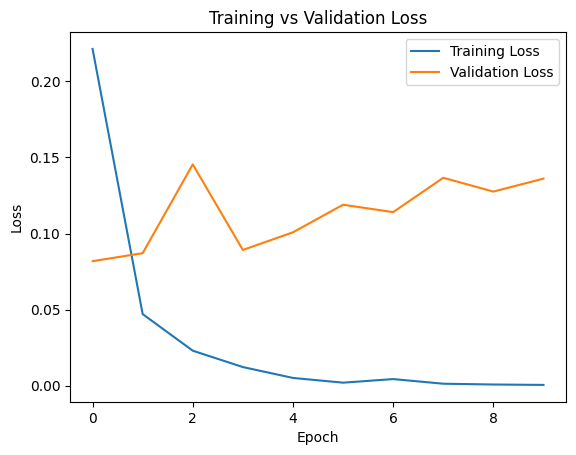

In [ ]:
# Plot training vs validation loss
# Membantu mendeteksi overfitting (jika gap terlalu besar)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

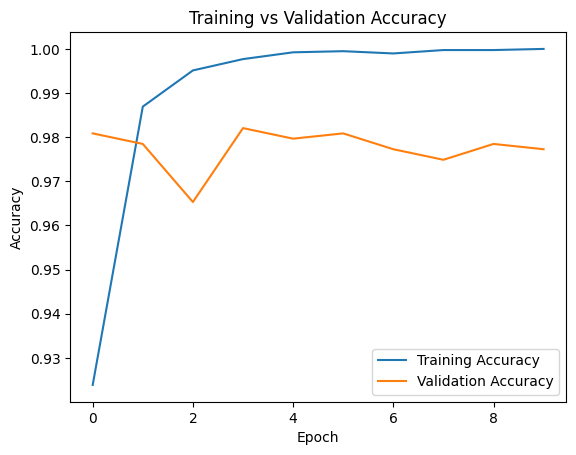

In [ ]:
# Plot training vs validation accuracy
# Menunjukkan progression performa model selama training
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

### confusion matrix

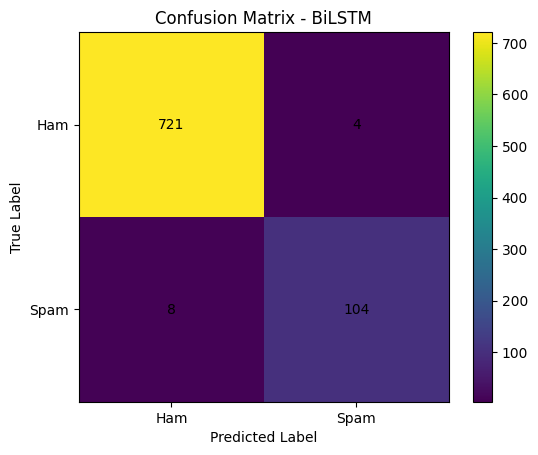

In [ ]:
# Visualisasi Confusion Matrix
# Menampilkan True Positive, True Negative, False Positive, False Negative
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - BiLSTM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ["Ham", "Spam"])
plt.yticks([0, 1], ["Ham", "Spam"])

# Tampilkan nilai di setiap cell
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.show()

## Model 2

In [ ]:
# Install library transformers untuk BERT/DistilBERT
# -q: quiet mode (tanpa output verbose)
!pip install -q transformers datasets accelerate

In [ ]:
import torch
import numpy as np
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


### Tokenizer BERT

In [ ]:
# Konversi label ke integer (diperlukan oleh BERT)
# Label harus dalam format int, bukan float
import numpy as np

y_train = np.asarray(y_train).astype(int)
y_val   = np.asarray(y_val).astype(int)
y_test  = np.asarray(y_test).astype(int)

In [ ]:
# Load BERT tokenizer (fast version)
# bert-base-uncased: lowercase, 110M parameters
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Konversi data ke format Hugging Face Dataset
# Format ini kompatibel dengan Trainer API
from datasets import Dataset

train_ds = Dataset.from_dict({
    "text": X_train,
    "label": y_train
})

val_ds = Dataset.from_dict({
    "text": X_val,
    "label": y_val
})

test_ds = Dataset.from_dict({
    "text": X_test,
    "label": y_test
})

### Tokenisasi

In [ ]:
# Fungsi untuk tokenisasi dengan BERT tokenizer
# - padding="max_length": pad semua ke max_length
# - truncation=True: potong jika melebihi max_length
# - max_length=128: panjang maksimal sequence
def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Terapkan tokenisasi ke semua dataset
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds   = val_ds.map(tokenize_function, batched=True)
test_ds  = test_ds.map(tokenize_function, batched=True)

# Set format ke PyTorch tensors
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

### Load model

In [ ]:
train_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


In [ ]:
# Load pretrained BERT model untuk sequence classification
# num_labels=2: binary classification (spam/ham)
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    problem_type="single_label_classification"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [ ]:
# Disable Weights & Biases logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Konfigurasi training arguments
# - eval_strategy: evaluasi setiap epoch
# - learning_rate: 2e-5 (standar untuk fine-tuning BERT)
# - batch_size: 16 (balance antara speed & memory)
# - num_train_epochs: 3 (cukup untuk fine-tuning)
# - fp16: mixed precision training (lebih cepat jika GPU support)
training_args = TrainingArguments(
    output_dir="./bert_spam",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    fp16=torch.cuda.is_available()
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Metric Evaluasi (Fokus Spam)

In [ ]:
# Fungsi untuk menghitung metrik evaluasi
# Fokus pada class Spam (positive class)
# - Precision: dari yang diprediksi spam, berapa yang benar spam
# - Recall: dari semua spam sebenarnya, berapa yang terdeteksi
# - F1: harmonic mean dari precision & recall
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

### Trainer & Training

In [ ]:
# Setup Trainer dan mulai fine-tuning
# Trainer API menyederhanakan proses training & evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

# Mulai training (akan memakan waktu lebih lama dari BiLSTM)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.069400,0.064632,0.989234,0.990476,0.928571,0.958525
2,0.009800,0.040474,0.991627,0.990654,0.946429,0.968037
3,0.006200,0.040051,0.991627,0.972973,0.964286,0.968610


TrainOutput(global_step=732, training_loss=0.040127010944762516, metrics={'train_runtime': 143.8181, 'train_samples_per_second': 81.374, 'train_steps_per_second': 5.09, 'total_flos': 769797170219520.0, 'train_loss': 0.040127010944762516, 'epoch': 3.0})

### Evaluasi

In [ ]:
# Evaluasi model BERT pada test set
# Menghitung semua metrik yang didefinisikan di compute_metrics
trainer.evaluate(test_ds)

{'eval_loss': 0.0638422742486,
 'eval_accuracy': 0.98805256869773,
 'eval_precision': 0.9811320754716981,
 'eval_recall': 0.9285714285714286,
 'eval_f1': 0.9541284403669725,
 'eval_runtime': 1.5082,
 'eval_samples_per_second': 554.963,
 'eval_steps_per_second': 35.141,
 'epoch': 3.0}

In [ ]:
predictions = trainer.predict(test_ds)


In [ ]:
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


In [ ]:
# Tampilkan classification report lengkap
# Menunjukkan precision, recall, f1-score per class
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["Ham", "Spam"]
))

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       725
        Spam       0.98      0.93      0.95       112

    accuracy                           0.99       837
   macro avg       0.99      0.96      0.97       837
weighted avg       0.99      0.99      0.99       837



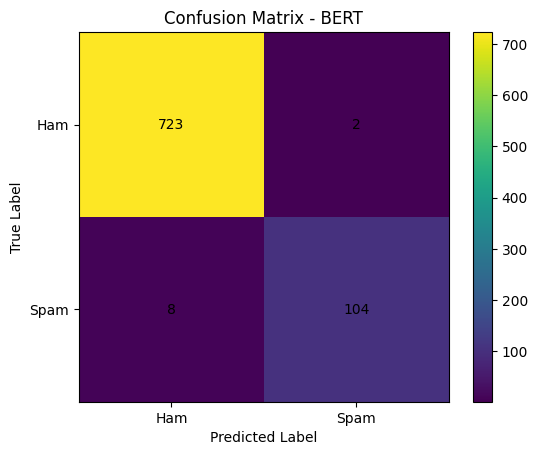

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - BERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ["Ham", "Spam"])
plt.yticks([0, 1], ["Ham", "Spam"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.show()


### Plot Loss & Acc

In [ ]:
logs = trainer.state.log_history


In [ ]:
train_loss = []
eval_loss = []
eval_accuracy = []
epochs = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])


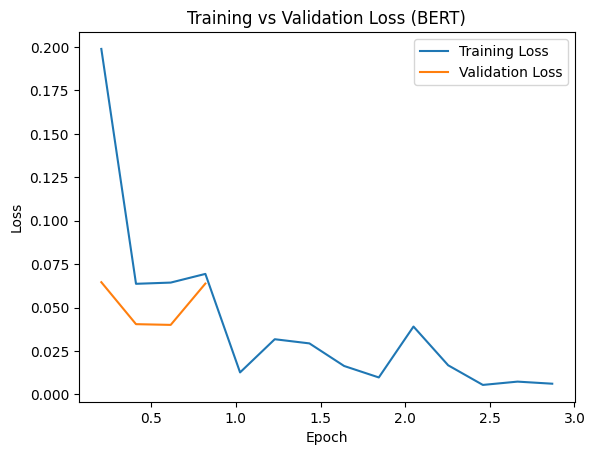

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss")
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (BERT)")
plt.legend()
plt.show()


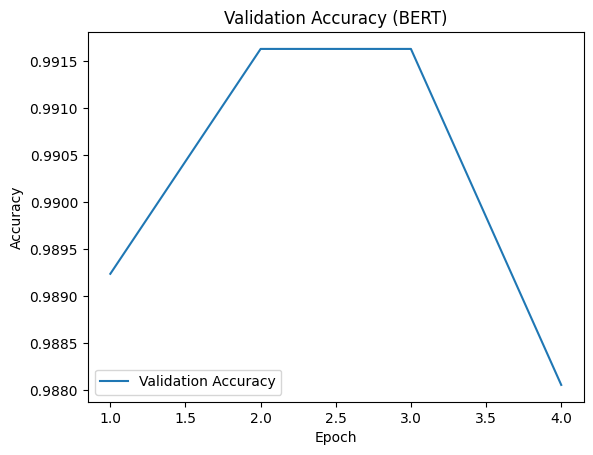

In [ ]:
plt.figure()
plt.plot(range(1, len(eval_accuracy) + 1), eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (BERT)")
plt.legend()
plt.show()


### Simpan model

In [ ]:
# Path untuk menyimpan model BERT yang sudah di-fine-tune
SAVE_PATH = "/content/drive/MyDrive/Semester 7/ML/P/UAP/Output"

In [ ]:
# Simpan model dan tokenizer
# Model disimpan dalam format safetensors dan config files
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

('/content/drive/MyDrive/Semester 7/ML/P/UAP/Output/tokenizer_config.json',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/Output/special_tokens_map.json',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/Output/vocab.txt',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/Output/added_tokens.json',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/Output/tokenizer.json')

## Model 3 (DistilBERT)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Load DistilBERT tokenizer
# DistilBERT: versi lebih ringan dari BERT (40% lebih kecil, 60% lebih cepat)
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Tokenizer DistilBERT

In [ ]:
from datasets import Dataset
import numpy as np

y_train = np.asarray(y_train).astype(int)
y_val   = np.asarray(y_val).astype(int)
y_test  = np.asarray(y_test).astype(int)

train_ds = Dataset.from_dict({"text": X_train, "label": y_train})
val_ds   = Dataset.from_dict({"text": X_val,   "label": y_val})
test_ds  = Dataset.from_dict({"text": X_test,  "label": y_test})


### Tokenisasi

In [ ]:
def tokenize_distil(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = train_ds.map(tokenize_distil, batched=True)
val_ds   = val_ds.map(tokenize_distil, batched=True)
test_ds  = test_ds.map(tokenize_distil, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

### Load Model DistilBERT (KUNCI FIX LOSS)

In [ ]:
# Load pretrained DistilBERT model
# DistilBERT mempertahankan 97% performa BERT dengan size lebih kecil
from transformers import DistilBertForSequenceClassification

model_distilbert = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    problem_type="single_label_classification"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### class weight

In [ ]:
# Hitung class weights untuk menangani imbalanced dataset
# Weight lebih besar untuk class minority (spam)
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# Pastikan y_train numpy array
y_train_np = np.array(y_train)

# Hitung balanced class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_np),
    y=y_train_np
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([0.5774, 3.7294])

In [ ]:
# Custom Trainer dengan weighted loss
# Menangani class imbalance dengan memberikan weight berbeda per class
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        **kwargs  # Penting untuk kompatibilitas dengan versi baru
    ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropyLoss dengan class weights
        loss_fct = nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )

        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )

        return (loss, outputs) if return_outputs else loss

### TrainingArguments (Lebih Cepat dari BERT)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./distilbert_spam_weighted",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none"
)


### Metric Evaluasi

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


### Trainer & Training

In [ ]:
# Setup WeightedTrainer dan mulai fine-tuning DistilBERT
# Menggunakan custom trainer dengan weighted loss
from transformers import Trainer

trainer = WeightedTrainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Training DistilBERT (lebih cepat dari BERT)
trainer.train()

/tmp/ipython-input-1221635146.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.150600,0.072164,0.988038,0.955357,0.955357,0.955357
2,0.022700,0.055684,0.996411,1.000000,0.973214,0.986425
3,0.002400,0.060997,0.996411,1.000000,0.973214,0.986425


TrainOutput(global_step=732, training_loss=0.08593437927546071, metrics={'train_runtime': 143.0061, 'train_samples_per_second': 81.836, 'train_steps_per_second': 5.119, 'total_flos': 387566491617792.0, 'train_loss': 0.08593437927546071, 'epoch': 3.0})

### Evaluasi Test Set

In [ ]:
trainer.evaluate(test_ds)


{'eval_loss': 0.19957956671714783,
 'eval_accuracy': 0.98805256869773,
 'eval_precision': 0.9811320754716981,
 'eval_recall': 0.9285714285714286,
 'eval_f1': 0.9541284403669725,
 'eval_runtime': 2.8004,
 'eval_samples_per_second': 298.881,
 'eval_steps_per_second': 18.926,
 'epoch': 3.0}

In [ ]:
eval_result = trainer.evaluate()
eval_result


{'eval_loss': 0.06099722906947136,
 'eval_accuracy': 0.9964114832535885,
 'eval_precision': 1.0,
 'eval_recall': 0.9732142857142857,
 'eval_f1': 0.9864253393665159,
 'eval_runtime': 2.762,
 'eval_samples_per_second': 302.683,
 'eval_steps_per_second': 19.189,
 'epoch': 3.0}

### Simpan Model

In [ ]:
# Simpan DistilBERT model dan tokenizer
SAVE_PATH = "/content/drive/MyDrive/Semester 7/ML/P/UAP/distilbert_spam_model"

trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

('/content/drive/MyDrive/Semester 7/ML/P/UAP/distilbert_spam_model/tokenizer_config.json',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/distilbert_spam_model/special_tokens_map.json',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/distilbert_spam_model/vocab.txt',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/distilbert_spam_model/added_tokens.json',
 '/content/drive/MyDrive/Semester 7/ML/P/UAP/distilbert_spam_model/tokenizer.json')

### Evaluasi Model DistilBERT

In [ ]:
eval_result = trainer.evaluate()
eval_result


{'eval_loss': 0.06099722906947136,
 'eval_accuracy': 0.9964114832535885,
 'eval_precision': 1.0,
 'eval_recall': 0.9732142857142857,
 'eval_f1': 0.9864253393665159,
 'eval_runtime': 2.9172,
 'eval_samples_per_second': 286.576,
 'eval_steps_per_second': 18.168,
 'epoch': 3.0}

### Plot Loss & Accuracy

In [ ]:
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_acc = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_acc.append(log["eval_accuracy"])


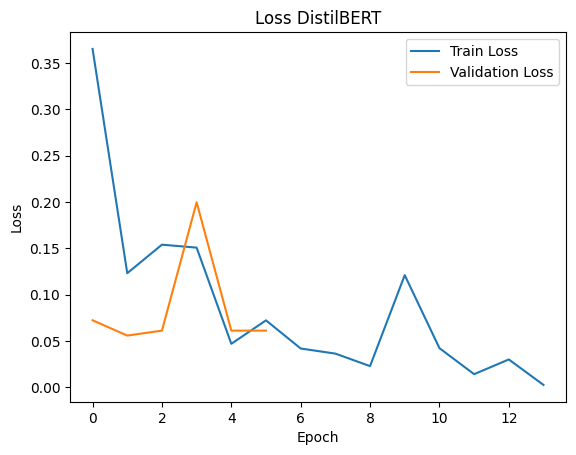

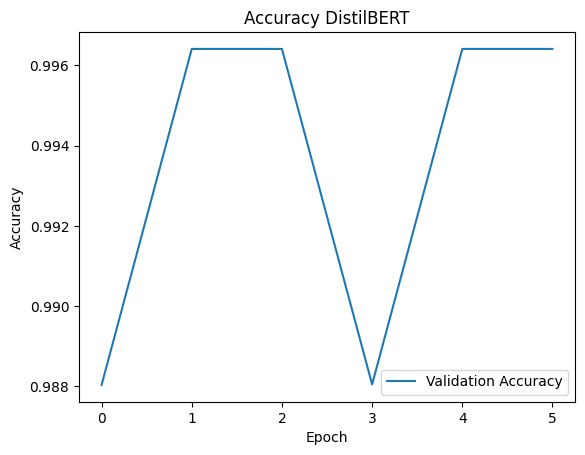

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss DistilBERT")
plt.show()

plt.figure()
plt.plot(eval_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy DistilBERT")
plt.show()


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)


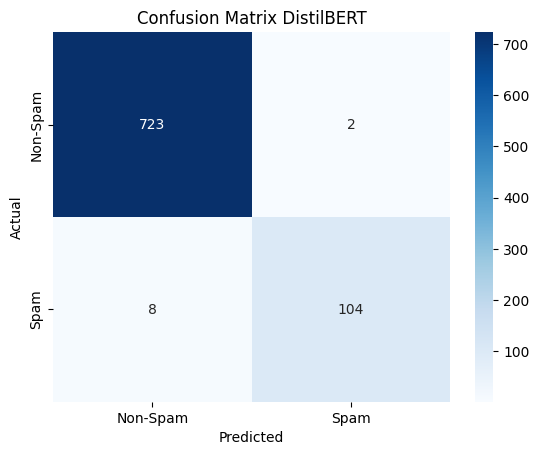

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Spam", "Spam"],
            yticklabels=["Non-Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix DistilBERT")
plt.show()


# Perbandingan 3 Model

In [ ]:
# Buat tabel perbandingan hasil evaluasi 3 model
# Hasil ini dari evaluasi pada test set
import pandas as pd

results = {
    "Model": ["BiLSTM", "BERT", "DistilBERT"],
    "Accuracy": [0.99, 0.98, 0.98],
    "Precision": [0.99, 0.98, 0.98],
    "Recall": [0.96, 0.92, 0.92],
    "F1-Score": [0.98, 0.95, 0.95]
}

df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,Recall,F1-Score
0,BiLSTM,0.99,0.99,0.96,0.98
1,BERT,0.98,0.98,0.92,0.95
2,DistilBERT,0.98,0.98,0.92,0.95


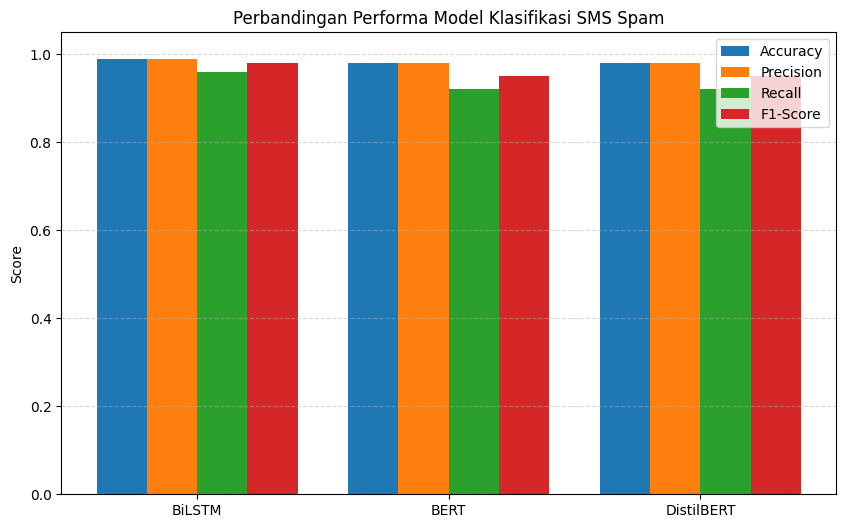

In [ ]:
# Visualisasi perbandingan semua metrik antar model
# Bar chart untuk membandingkan Accuracy, Precision, Recall, F1-Score
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
x = np.arange(len(df_results["Model"]))
width = 0.2

plt.figure(figsize=(10,6))

# Plot bar untuk setiap metrik
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, df_results[metric], width, label=metric)

plt.xticks(x + width*1.5, df_results["Model"])
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Perbandingan Performa Model Klasifikasi SMS Spam")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

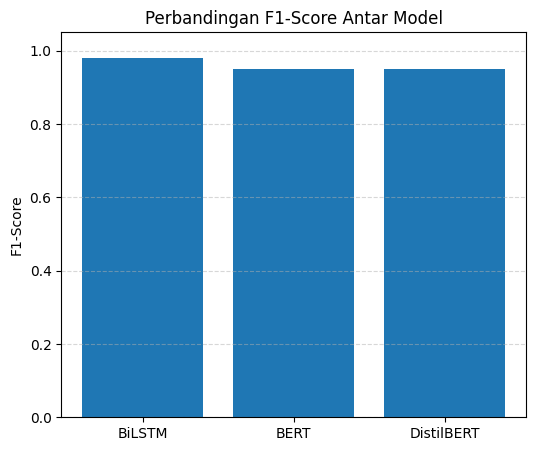

In [ ]:
# Visualisasi khusus F1-Score
# F1-Score adalah metrik paling penting untuk klasifikasi imbalanced
plt.figure(figsize=(6,5))
plt.bar(df_results["Model"], df_results["F1-Score"])
plt.ylim(0, 1.05)
plt.ylabel("F1-Score")
plt.title("Perbandingan F1-Score Antar Model")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()